# Bayesian Switch Point Analysis

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [5]:
def evaluate(tensors):
    if tf.executing_eagerly():
        return tf.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.is_tensor(t) else t
             for t in tf.nest.flatten(tensors)])
    return sess.run(tensors)

## Poisson Distribution

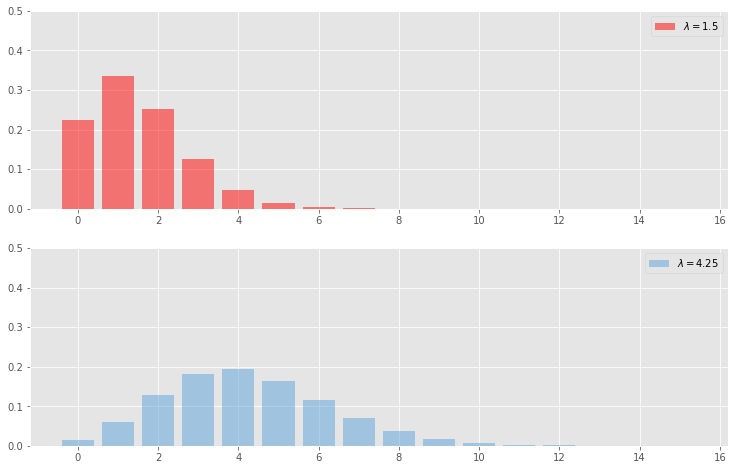

In [6]:
rate = [[1.5], [4.25]]
var_poi = tfd.Poisson(rate=rate)
poi_pmf = var_poi.prob(np.arange(0, 16))
color_blue = '#5DA5DA'
colors = ['red', color_blue]
plt.figure(figsize=(12.5, 8))
for i in range(2):
    ax = plt.subplot(2, 1, i+1)
    plt.bar(np.arange(0, 16), poi_pmf[i], color=colors[i],
            label='$\lambda={}$'.format(rate[i][0]), alpha=0.5)
    plt.ylim([0, 0.5])
    plt.legend()

## Data

In [7]:
count_data = tf.constant([
    13,  24,   8,  24,   7,  35,  14,  11,  15,  11,  22,  22,  11,  57,  
    11,  19,  29,   6,  19,  12,  22,  12,  18,  72,  32,   9,   7,  13,  
    19,  23,  27,  20,   6,  17,  13,  10,  14,   6,  16,  15,   7,   2,  
    15,  15,  19,  70,  49,   7,  53,  22,  21,  31,  19,  11,  18,  20,  
    12,  35,  17,  23,  17,   4,   2,  31,  30,  13,  27,   0,  39,  37,   
    5,  14,  13,  22,
], dtype=tf.float32)
n_count_data = tf.shape(count_data)
days = tf.range(n_count_data[0],dtype=tf.int32)

(0.0, 74.0)

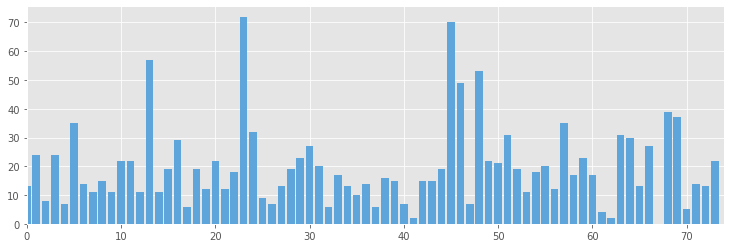

In [8]:
plt.figure(figsize=(12.5, 4))
plt.bar(days.numpy(), count_data, color=color_blue)
plt.xlim(0, n_count_data[0].numpy())

In [9]:
def joint_log_prob(count_data, lambda_1, lambda_2, tau):
    alpha = (1 / tf.reduce_mean(count_data))
    var_lambda_1 = tfd.Exponential(rate=alpha)
    var_lambda_2 = tfd.Exponential(rate=alpha)
    
    var_tau = tfd.Uniform(low=0., high=1.)
    # lambda 1 vs 2 indices
    tau_scaled = tf.convert_to_tensor(tau * count_data.shape[0], dtype=tf.float32)
    indices = tf.cast(tf.range(count_data.shape[0]), tf.float32)
    lambda_ = tf.gather([lambda_1, lambda_2],
                  indices=tf.cast(tau_scaled <= indices, dtype=tf.int32))
    var_obs = tfd.Poisson(rate=lambda_)
    return (
        var_lambda_1.log_prob(lambda_1)
        + var_lambda_2.log_prob(lambda_2)
        + var_tau.log_prob(tau)
        + tf.reduce_sum(var_obs.log_prob(count_data))
    )

In [10]:
def log_posterior(lambda_1, lambda_2, tau):
    return joint_log_prob(count_data, lambda_1, lambda_2, tau)

In [11]:
# wrap the mcmc sampling call in a @tf.function to speed it up
@tf.function(autograph=False)
def graph_sample_chain(*args, **kwargs):
  return tfp.mcmc.sample_chain(*args, **kwargs)

num_burnin_steps = 1000
num_results = 2000


# Set the chain's start state.
initial_chain_state = [
    tf.cast(tf.reduce_mean(count_data), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda_1"),
    tf.cast(tf.reduce_mean(count_data), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda_2"),
    0.5 * tf.ones([], dtype=tf.float32, name="init_tau"),
]


# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Sigmoid(),   # Maps [0,1] to R.  
]

step_size = 0.2

kernel=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=log_posterior,
            num_leapfrog_steps=2,
            step_size=step_size,
            state_gradients_are_stopped=True),
        bijector=unconstraining_bijectors)

kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=kernel, num_adaptation_steps=int(num_burnin_steps * 0.8))


# Sample from the chain.
[
    lambda_1_samples,
    lambda_2_samples,
    posterior_tau,
], kernel_results = graph_sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=initial_chain_state,
    kernel = kernel)
    
tau_samples = tf.floor(posterior_tau * tf.cast(tf.size(count_data),dtype=tf.float32))

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


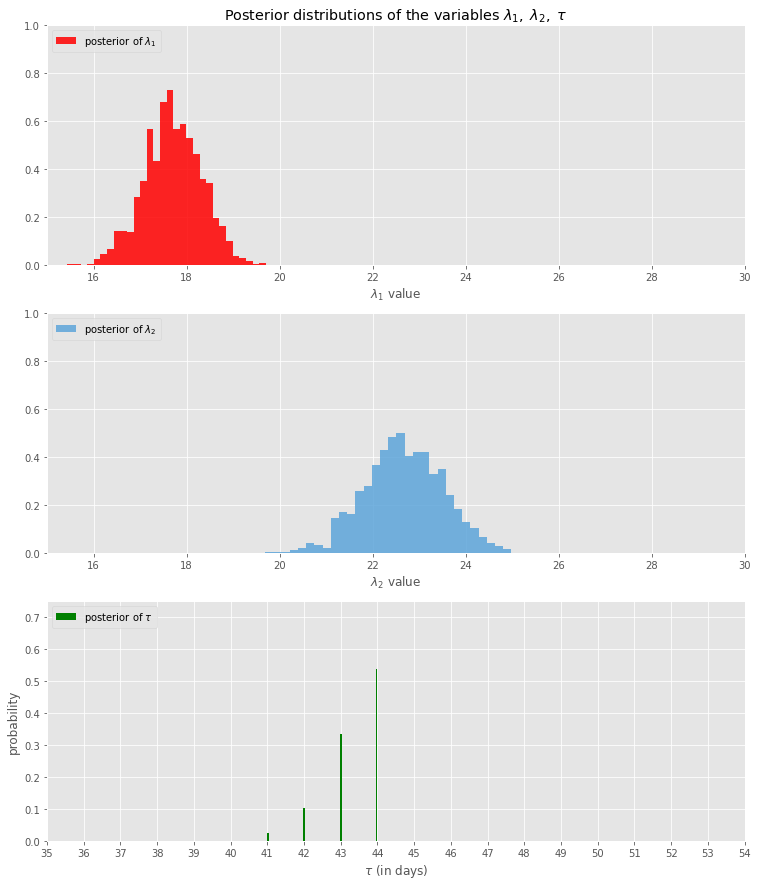

In [25]:
plt.figure(figsize=(12.5, 15))
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(evaluate(lambda_1_samples), histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_1$", color=colors[0], density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel(r"$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(evaluate(lambda_2_samples), histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_2$", color=colors[1], density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel(r"$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(evaluate(tau_samples), bins=n_count_data[0], alpha=1,
         label=r"posterior of $\tau$",
         color='green', weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data[0]))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel(r"probability");

## Using `tfp_helper` for inference

In [26]:
from tfp_helper import evaluate, infer

In [27]:
initial_chain_state = [
    tf.cast(tf.reduce_mean(count_data), tf.float32),
    tf.cast(tf.reduce_mean(count_data), tf.float32),
    0.5,
]

In [28]:
azdata = infer(joint_log_prob, count_data,
              variables=['lambda_1', 'lambda_2', 'tau'],
              initial_chain_state=initial_chain_state,
              nsteps=30000,
              bijectors={
                  'lambda_1' : tfb.Exp(),
                  'lambda_2' : tfb.Exp(),
                  'tau' : tfb.Identity()
              })

In [29]:
import arviz as az

array([[<AxesSubplot:title={'center':'lambda_1'}>,
        <AxesSubplot:title={'center':'lambda_1'}>],
       [<AxesSubplot:title={'center':'lambda_2'}>,
        <AxesSubplot:title={'center':'lambda_2'}>],
       [<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>]], dtype=object)

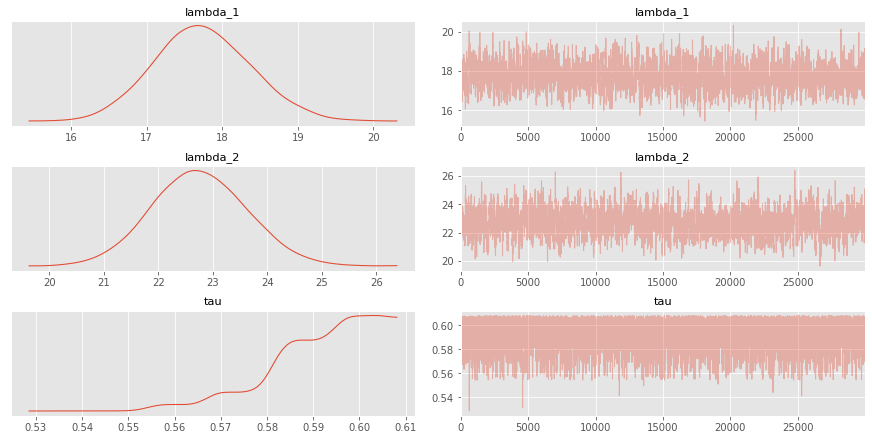

In [30]:
az.plot_trace(azdata)

## Samples

In [99]:
lambda_1 = azdata.posterior.lambda_1.data
lambda_2 = azdata.posterior.lambda_2.data
tau = azdata.posterior.tau.data

In [47]:
tau_scaled = np.floor(tau * count_data.shape[0])
count, day = np.histogram(tau_scaled, np.arange(count_data.shape[0]))

In [49]:
count / count.sum()

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e-04,
       7.66666667e-04, 3.40333333e-02, 1.04000000e-01, 3.65133333e-01,
       4.95966667e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [55]:
day

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73])

In [52]:
count

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     3,    23,  1021,  3120, 10954, 14879,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

In [54]:
count

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     3,    23,  1021,  3120, 10954, 14879,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

In [57]:
day.shape, count.shape

((74,), (73,))

<BarContainer object of 73 artists>

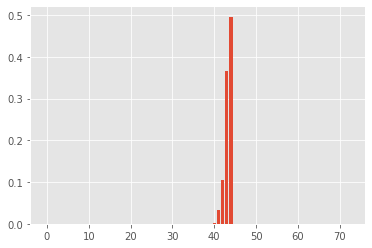

In [60]:
plt.bar(day[:-1], count / count.sum())

In [62]:
days = np.arange(count.shape[0])

In [90]:
expectation = np.zeros(count_data.shape[0])

In [69]:
change_indices = np.where(count > 0)

In [73]:
change_indices[0][0]

39

In [100]:
expectation[:change_indices[0][0]] = lambda_1.mean()

In [101]:
expectation[change_indices[0][-1]:] = lambda_2.mean()

In [105]:
a, b = change_indices[0][0], change_indices[0][-1]

In [108]:
countp = count / count.sum()

In [111]:
lambda_1.mean()

17.741743

In [116]:
expectation[a:b] = ((1 - countp[a:b])*lambda_1.mean()) + (countp[a:b] * lambda_2.mean())

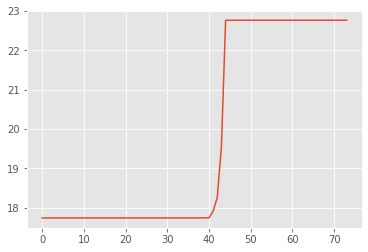

In [117]:
plt.plot(expectation)

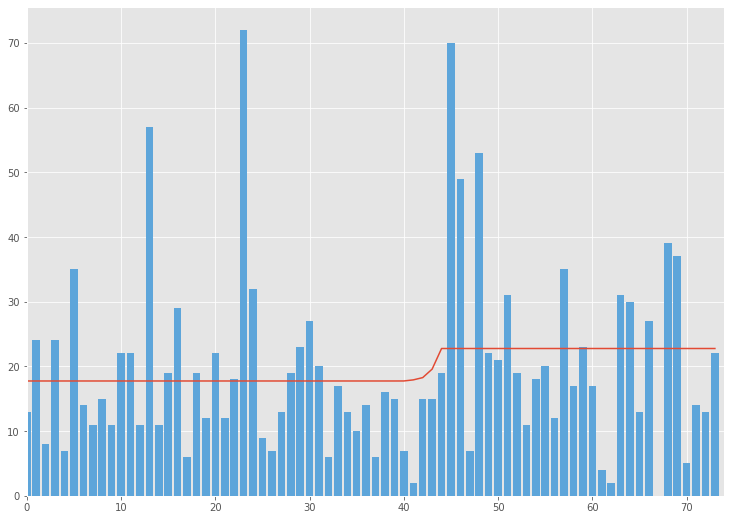

In [122]:
plt.figure(figsize=(12.5, 9))
days = tf.range(n_count_data[0],dtype=tf.int32)
plt.bar(days.numpy(), count_data, color=color_blue)
plt.xlim(0, n_count_data[0].numpy())
plt.plot(days.numpy(), expectation)